# Anaylsis of the results

In [125]:
# load pickle
import pickle
from utils import *
import os
import re

def extract_uppercase_letters(text):
    # Define the regex pattern to match the segment between "answer is" and the period.
    pattern = r'answer is ([^.]*?)\.'

    # Search the text for the pattern
    match = re.search(pattern, text)

    if match:
        # Extract the relevant segment
        segment = match.group(1)
        # Find all uppercase letters in the segment
        uppercase_letters = re.findall(r'[A-Z]', segment)
        return uppercase_letters
    else:
        return []
    
def evaluation_sampling_cot(llm_answer, exam_Answers, num_of_correct_answer):
    """Analyse the answer given by the LLM and compare it with the exam answers.

    Keyword arguments:
    llm_answer -- the answer string given by the LLM
    exam_Answers -- the list of answers from the exam
    """

    answerLLM = extract_uppercase_letters(llm_answer)
    if answerLLM is not None:
        num_of_correct_llm_Answers, too_many_answ, number_of_incorrect_llm_answers = compare_answers(answerLLM, exam_Answers)
        if num_of_correct_llm_Answers == num_of_correct_answer and too_many_answ == False:
            answered_correctly = True
        else:
            answered_correctly = False 
        return num_of_correct_llm_Answers, answerLLM, too_many_answ, answered_correctly, number_of_incorrect_llm_answers
    else:
         return -1
    
def update_stats_cot(llm_exam_result):
    for index, row in llm_exam_result.iterrows():
        #print(row["LLM_Answer"])
        num_of_correct_llm_answer, answerLLm, too_many_answers, answered_correctly, number_of_incorrect_llm_answers = evaluation_sampling_cot(row["LLM_Answer"], row["Exam_Answers"], row["NumberOfCorrectExamAnswers"])
        #modify the dataframe accordign to the evaluation
        llm_exam_result.at[index, 'NumberOfIncorrectLLMAnswers'] = number_of_incorrect_llm_answers
        llm_exam_result.at[index, 'NumberOfCorrectLLMAnswers'] = num_of_correct_llm_answer
        llm_exam_result.at[index, 'Ratio'] = num_of_correct_llm_answer/row["NumberOfCorrectExamAnswers"]
        llm_exam_result.at[index, 'Answered_Correctly'] = answered_correctly
        llm_exam_result.at[index, 'Too_Many_answers'] = too_many_answers
        llm_exam_result.at[index, 'NumberOfCorrectLLMAnswers'] = num_of_correct_llm_answer
    return llm_exam_result

def stats_from_pickle(folder_paths, cot=False):
    shuffled_evalutation_df = pd.DataFrame(columns=[ 'Number of Questions','Correctly Answered','Incorrectly Answered','Accuracy','Accuracy Partial'])

    pkl_files = []
    for folder_path in folder_paths:
        for root, dirs, files in os.walk(folder_path):
            for file in files:
                if "shuffled" in file and file.endswith(".pkl"):
                    pkl_files.append(os.path.join(root, file))
                    
    for file in pkl_files:
        llm_exam_result = pickle.load(open(file, "rb"))
        #print(extract_uppercase_letters(llm_exam_result["LLM_Answer"][0]))
        if cot:
            llm_exam_result = update_stats_cot(llm_exam_result)
        evaluation_df = evaluation(llm_exam_result)
        #Concat the evaluation dataframe to the complete dataframe
        shuffled_evalutation_df = pd.concat([shuffled_evalutation_df, evaluation_df], ignore_index=True)
    model_statistics = calculate_model_statistics(shuffled_evalutation_df)
    #sort the model statistics by accuracy
    return model_statistics.sort_values(by="Accuracy Mean", ascending=False, ignore_index=True)

import numpy as np
def plot_evaluation_CCNA(evaluation_df, hline_accuracy=None, hline_partial=None, title=None, save_path=None):
    """
    Plots evaluation metrics from a DataFrame containing columns:
        - 'Model'
        - 'Accuracy Mean', 'Accuracy Min', 'Accuracy Max'
        - 'Accuracy Partial Mean', 'Accuracy Partial Min', 'Accuracy Partial Max'
    """

    # Define a list of colors for the models
    colors = plt.cm.Set2(np.linspace(0, 1, len(evaluation_df)))

    # Define bar width
    bar_width = 0.5  # Increase bar width for thicker bars

    # --- Subplot 1: Accuracy ---
    fig, axs = plt.subplots(1, 2, figsize=(14, 6))

    for i, model in enumerate(evaluation_df['Model']):
        bars = axs[0].bar(i + bar_width * i, evaluation_df.loc[i, 'Accuracy Mean'], bar_width, 
                   yerr=[[abs(evaluation_df.loc[i, 'Accuracy Mean'] - evaluation_df.loc[i, 'Accuracy Min'])], [abs(evaluation_df.loc[i, 'Accuracy Max'] - evaluation_df.loc[i, 'Accuracy Mean'])]],
                   label=model, color=colors[i % len(colors)], capsize=5)

    axs[0].set_ylabel('Accuracy (%)')
    axs[0].set_title('Accuracy Mean with Error Bars (Max and Min)', fontsize=12)
    axs[0].set_xticks([i + bar_width * i for i in range(len(evaluation_df['Model']))])
    axs[0].set_xticklabels(evaluation_df['Model'], rotation=45, ha='right', fontsize=10)
    #axs[0].legend()
    axs[0].set_ylim([0, 1])
    axs[0].yaxis.set_major_locator(mtick.MultipleLocator(0.1))
    axs[0].yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
    axs[0].grid(True, linestyle='dotted', axis='y')

    # Add horizontal line to Accuracy subplot
    if hline_accuracy is not None:
        axs[0].axhline(y=hline_accuracy, color='r', linestyle='--')

    # --- Subplot 2: Partial Accuracy ---
    for i, model in enumerate(evaluation_df['Model']):
        bars = axs[1].bar(i + bar_width * i, evaluation_df.loc[i, 'Accuracy Partial Mean'], bar_width,
                   yerr=[[abs(evaluation_df.loc[i, 'Accuracy Partial Mean'] - evaluation_df.loc[i, 'Accuracy Partial Min'])], [abs(evaluation_df.loc[i, 'Accuracy Partial Max'] - evaluation_df.loc[i, 'Accuracy Partial Mean'])]],
                   label=model, color=colors[i % len(colors)], capsize=5)

    axs[1].set_ylabel('Accuracy Partial (%)')
    axs[1].set_title('Accuracy Partial Mean with Error Bars (Max and Min)', fontsize=12)
    axs[1].set_xticks([i + bar_width * i for i in range(len(evaluation_df['Model']))])
    axs[1].set_xticklabels(evaluation_df['Model'], rotation=45, ha='right', fontsize=10)
    #axs[1].legend()
    axs[1].set_ylim([0, 1])
    axs[1].yaxis.set_major_locator(mtick.MultipleLocator(0.1))
    axs[1].yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
    axs[1].grid(True, linestyle='dotted', axis='y')

    # Add horizontal line to Partial Accuracy subplot
    if hline_partial is not None:
        axs[1].axhline(y=hline_partial, color='r', linestyle='--')

    fig.tight_layout(pad=1.2)  # Decrease padding for closer plots

    # Add title to the figure
    if title is not None:
        fig.suptitle(title, fontsize=16, y=1.05)

    plt.show()



# CCNA & CCNP 5 Shot Anaylsis

/tmp/ipykernel_570361/2584201050.py:72: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  shuffled_evalutation_df = pd.concat([shuffled_evalutation_df, evaluation_df], ignore_index=True)


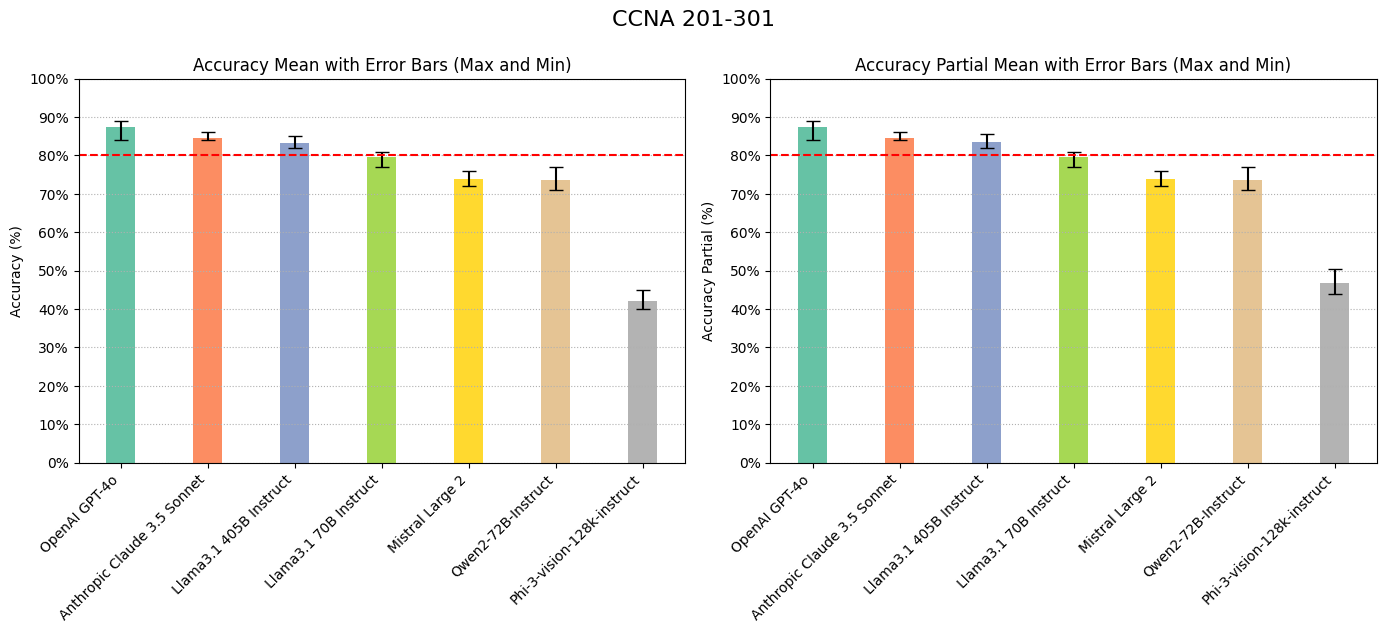

In [126]:
CCNA_folder_paths = ["../results/100_questions_5_Shot_201-301-CCNA_2024_08_07_15_43_FULL_RERUN","../results/100_questions_5_Shot_201-301-CCNA_2024_08_07_13_08_llam31_405b_fp16"]
CCNA_model_statistics = stats_from_pickle(CCNA_folder_paths)
title="CCNA 201-301"
plot_evaluation_CCNA(CCNA_model_statistics, hline_accuracy=0.8, hline_partial=0.8, title=title)

/tmp/ipykernel_570361/2584201050.py:72: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  shuffled_evalutation_df = pd.concat([shuffled_evalutation_df, evaluation_df], ignore_index=True)


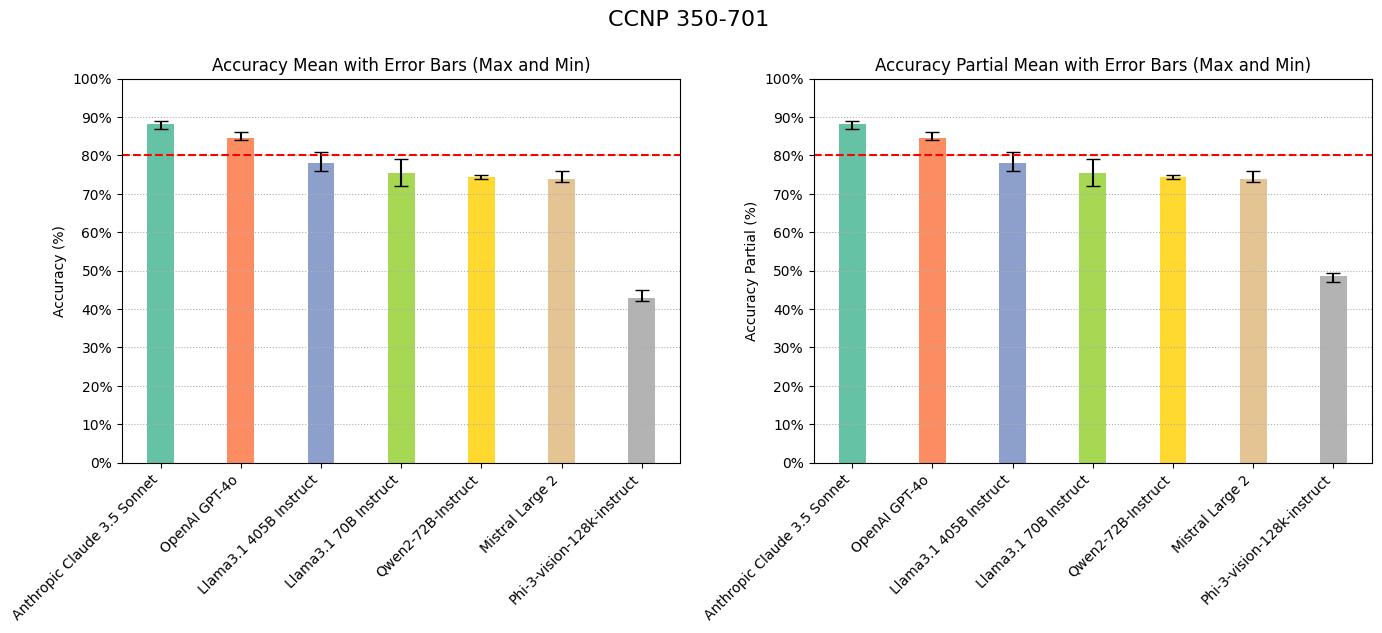

In [127]:
CCNP_folder_paths = [
    "../results/100_questions_5_Shot_350-701-CCNP_2024_08_06_15_28",
               "../results/100_questions_5_Shot_350-701-CCNP_2024_08_06_18_04",
               "../results/100_questions_5_Shot_350-701-CCNP_2024_08_06_18_15"
               ]
CCNP_model_statistics = stats_from_pickle(CCNP_folder_paths)
title="CCNP 350-701"
plot_evaluation_CCNA(CCNP_model_statistics, hline_accuracy=0.8, hline_partial=0.8, title=title)

# COT 

/tmp/ipykernel_570361/4271745252.py:72: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  shuffled_evalutation_df = pd.concat([shuffled_evalutation_df, evaluation_df], ignore_index=True)


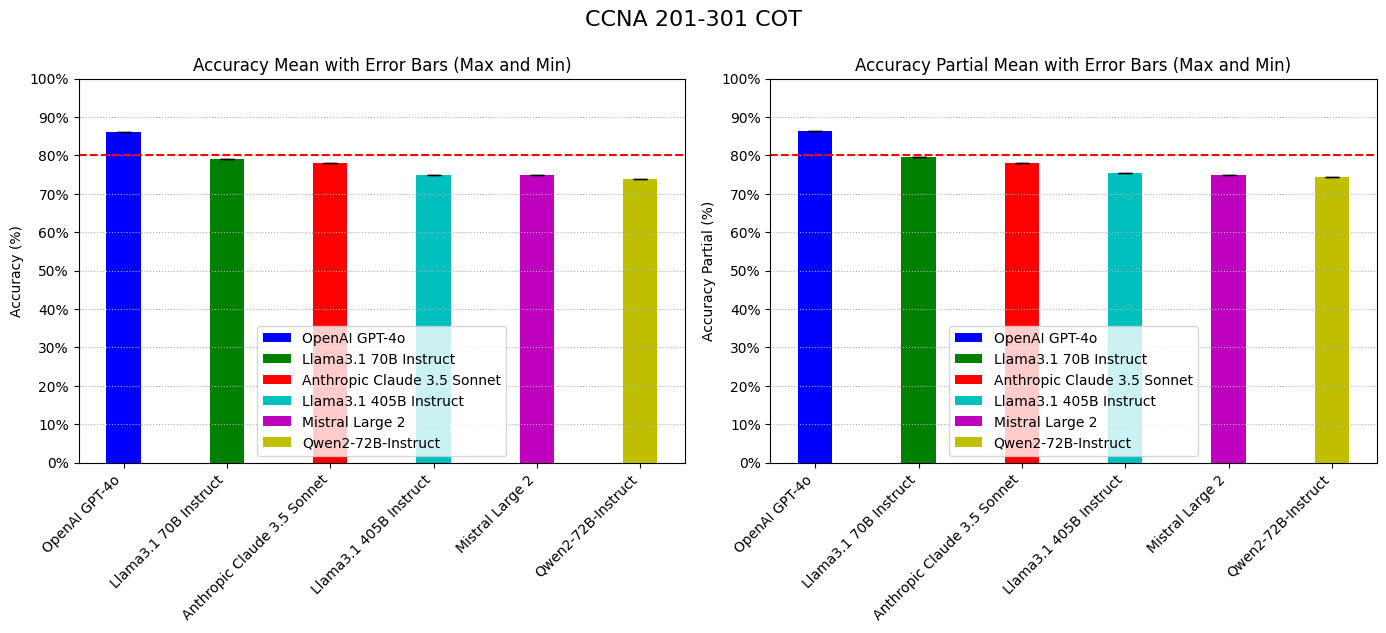

In [107]:
CCNP_Vision_path = [
    #"../results/100_questions_0_Shot_COT_201-301-CCNA_2024_08_06_19_15",
    "../results/100_questions_0_Shot_COT_201-301-CCNA_2024_08_06_20_49",
    "../results/100_questions_0_Shot_COT_201-301-CCNA_2024_08_06_20_50",
    "../results/100_questions_0_Shot_COT_201-301-CCNA_2024_08_06_22_17",
    "../results/100_questions_0_Shot_COT_201-301-CCNA_2024_08_07_13_51"
    ]
CCNA_COTmodel_statistics = stats_from_pickle(CCNP_Vision_path,cot=True)
title="CCNA 201-301 COT"
plot_evaluation_CCNA(CCNA_COTmodel_statistics, hline_accuracy=0.8, hline_partial=0.8, title=title)

(array([0, 1, 2, 3, 4, 5]),
 [Text(0, 0, 'Anthropic Claude 3.5 Sonnet'),
  Text(1, 0, 'Llama3.1 405B Instruct'),
  Text(2, 0, 'Llama3.1 70B Instruct'),
  Text(3, 0, 'Mistral Large 2'),
  Text(4, 0, 'OpenAI GPT-4o'),
  Text(5, 0, 'Qwen2-72B-Instruct')])

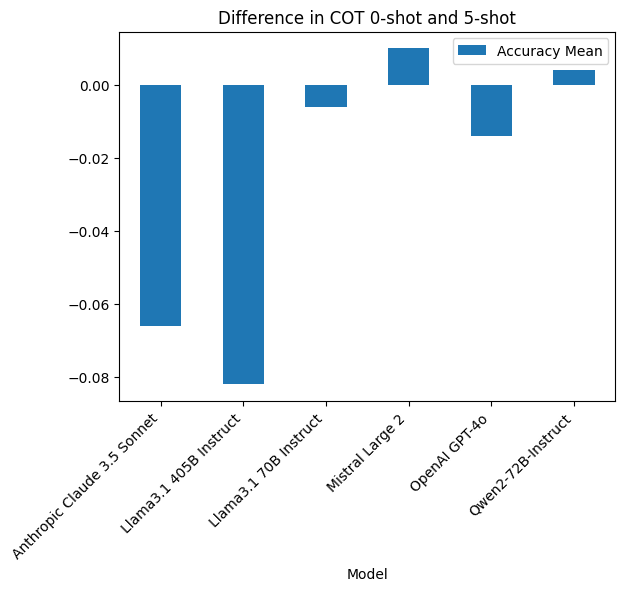

In [135]:
# plot the difference between the two Accuracy Partial and Accuracy
(CCNA_COTmodel_statistics.set_index("Model")["Accuracy Mean"] - CCNA_model_statistics.set_index("Model")["Accuracy Mean"]).dropna().plot(kind="bar", title="Difference in COT 0-shot and 5-shot", legend=True)
#the 0 should be in the midel of the plot so negativ values are shown on the bottom and positive on the top
plt.xticks(rotation=45, ha='right')

(array([0, 1, 2, 3, 4, 5, 6]),
 [Text(0, 0, 'OpenAI GPT-4o'),
  Text(1, 0, 'Anthropic Claude 3.5 Sonnet'),
  Text(2, 0, 'Llama3.1 405B Instruct'),
  Text(3, 0, 'Llama3.1 70B Instruct'),
  Text(4, 0, 'Mistral Large 2'),
  Text(5, 0, 'Qwen2-72B-Instruct'),
  Text(6, 0, 'Phi-3-vision-128k-instruct')])

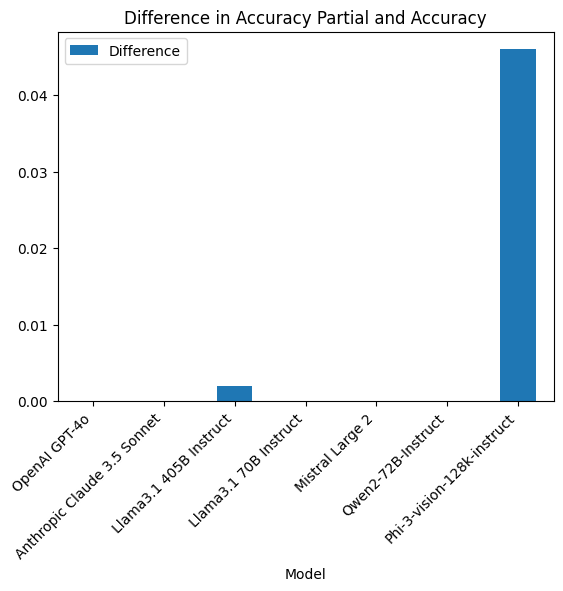

In [133]:
# plot the difference between the two Accuracy Partial and Accuracy
CCNA_model_statistics["Difference"] = CCNA_model_statistics["Accuracy Partial Mean"] - CCNA_model_statistics["Accuracy Mean"]
CCNA_model_statistics.set_index("Model")["Difference"].plot(kind="bar", title="Difference in Accuracy Partial and Accuracy", legend=True)
plt.xticks(rotation=45, ha='right')
#the 0 should be in the midel of the plot so negativ values are shown on the bottom and positive on the top

# COT vs 5 shot

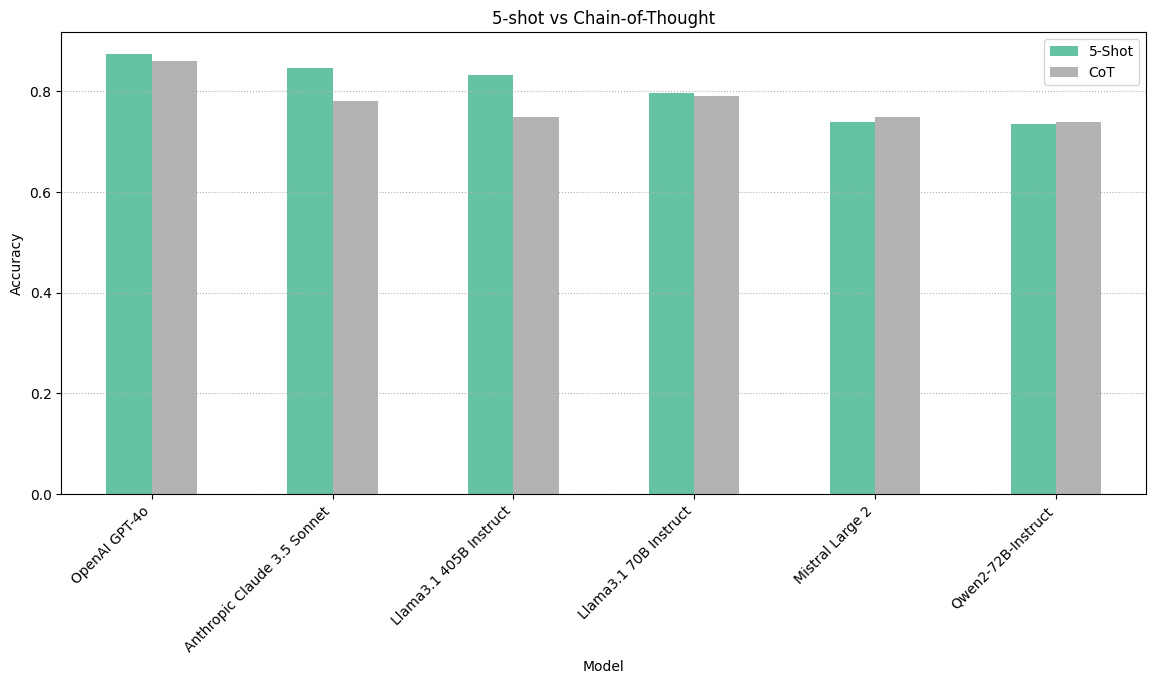

In [120]:
import numpy as np
llm_result_dfs= [CCNA_model_statistics.set_index("Model"),CCNA_COTmodel_statistics.set_index("Model")]
df_names= ["CCNA 5-shot","CCNA COT"]


# Define colors for the models
colors = plt.cm.Set2(np.linspace(0, 1, len(llm_result_dfs)))
# Define bar width and gap
bar_width = 0.2  # Decrease bar width for side-by-side bars with a gap
gap = 1.0 / (len(llm_result_dfs) + 1)

# Merge Results and rename columns
df1 = CCNA_model_statistics.set_index("Model")[["Accuracy Mean"]].rename(columns={'Accuracy Mean': '5-Shot'})
df2 = CCNA_COTmodel_statistics.set_index("Model").rename(columns={'Accuracy Mean': 'CoT'})[["CoT"]]
merged_df = pd.merge(df1,df2, on='Model')

#merged_df = merged_df.drop_duplicates(subset='Model', keep='first', ignore_index=True)
#merged_df = merged_df.sort_values(by="Accuracy_HELM", ascending=False, ignore_index=True)


#merged_df.set_index('Model', inplace=True)
merged_df.plot(kind='bar', figsize=(14, 6),color=colors)

plt.ylabel('Accuracy')
plt.title('5-shot vs Chain-of-Thought')
plt.xticks(rotation=45, ha='right')
plt.grid(True, linestyle='dotted', axis='y')
#plt.show()


plt.show()

# All Together

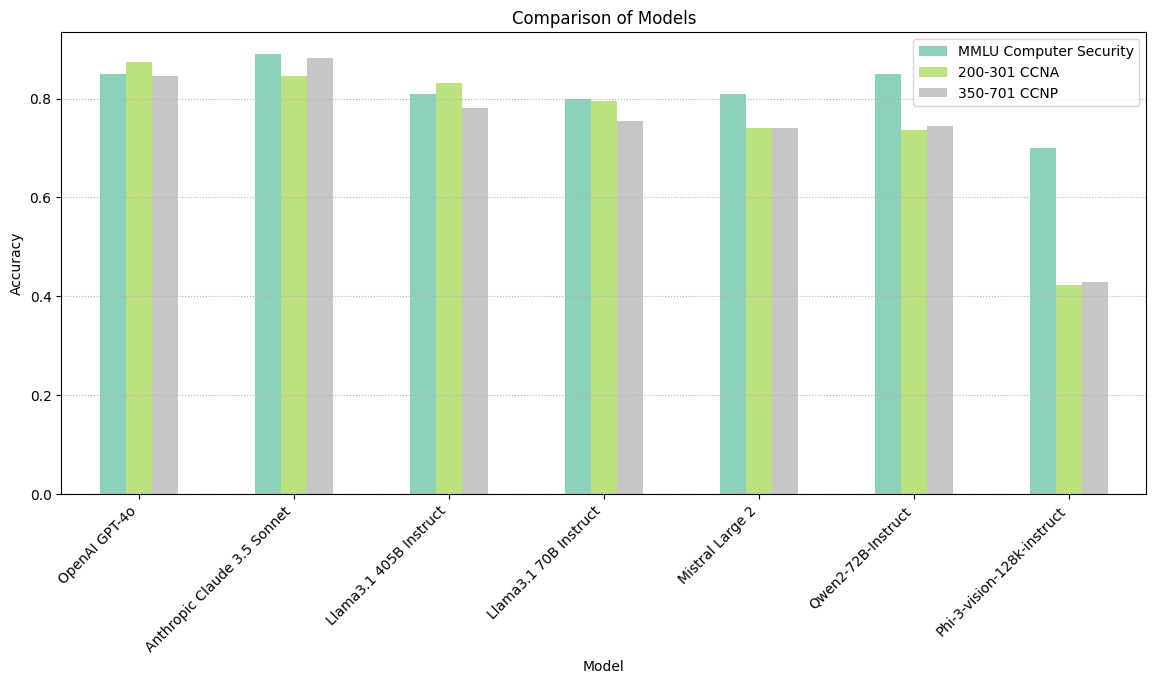

In [117]:
import numpy as np

helm_result = pd.read_csv("../data/helm_sec_mmlu_results.csv")
#,CCNA_COTmodel_statistics.set_index("Model")
llm_result_dfs= [CCNA_model_statistics.set_index("Model"),CCNP_model_statistics.set_index("Model")]
df_names= ["200-301 CCNA","350-701 CCNP", "MMLU Computer Security"]


# Define colors for the models
#colors = plt.cm.rainbow(np.linspace(0, 1, len(llm_result_dfs)))
colors = plt.cm.Set2(np.linspace(0, 1, len(merged_df.columns)))


# Define bar width and gap
bar_width = 0.2  # Decrease bar width for side-by-side bars with a gap
gap = 1.0 / (len(llm_result_dfs) + 1)

# Merge Results and rename columns
merged_df = helm_result.rename(columns={'Accuracy': 'MMLU Computer Security'})
for i, llm_result_df in enumerate(llm_result_dfs):
    merged_df = pd.merge(merged_df, llm_result_df[["Accuracy Mean"]], on='Model')
    merged_df = merged_df.rename(columns={'Accuracy Mean': '{}'.format(df_names[i])})

merged_df = merged_df.drop_duplicates(subset='Model', keep='first', ignore_index=True)
merged_df = merged_df.sort_values(by="200-301 CCNA", ascending=False, ignore_index=True)


merged_df.set_index('Model', inplace=True)
merged_df.plot(kind='bar', figsize=(14, 6), color=colors, alpha=0.75)

plt.ylabel('Accuracy')
plt.title('Comparison of Models')
plt.xticks(rotation=45, ha='right')
plt.grid(True, linestyle='dotted', axis='y')
#plt.show()


plt.show()



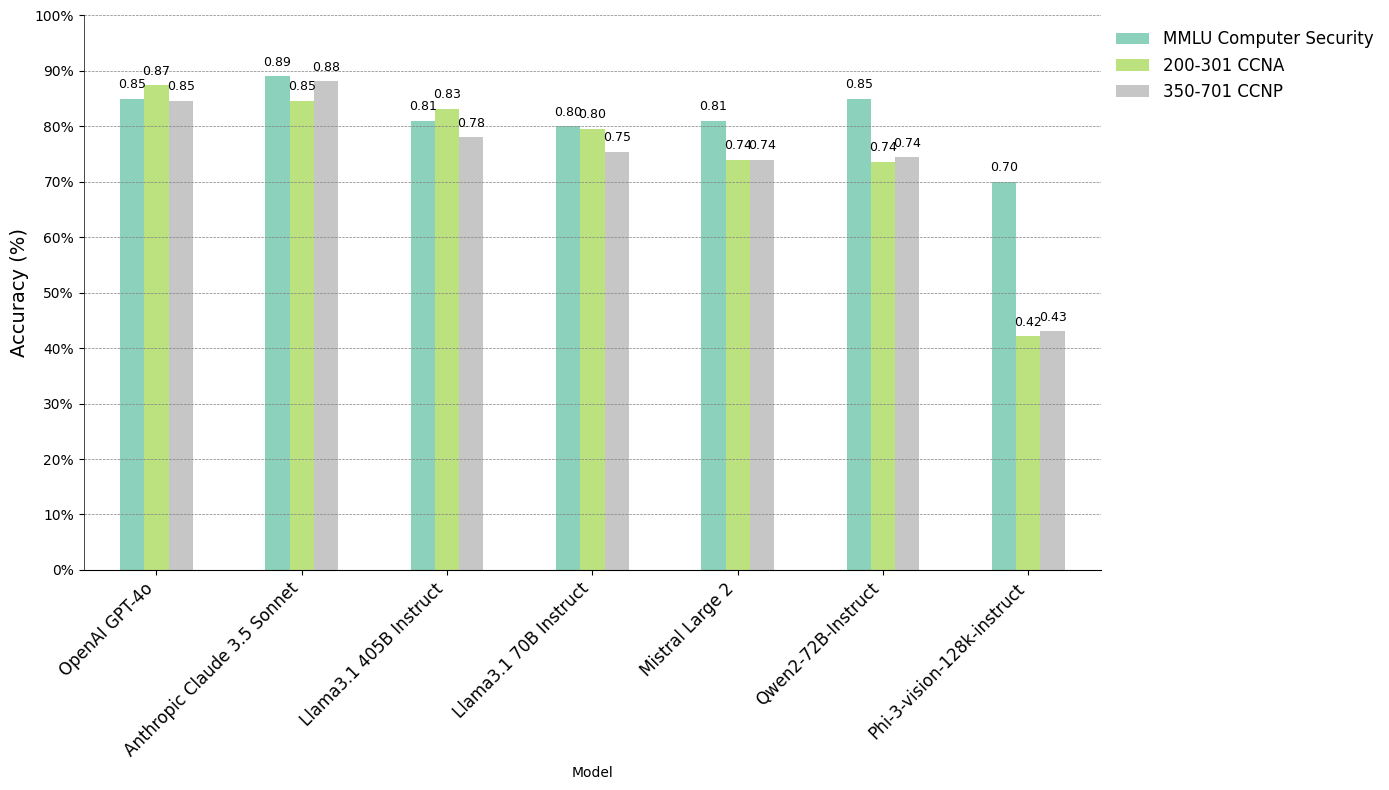

In [116]:
# Plot settings
fig, ax = plt.subplots(figsize=(14, 8))
colors = plt.cm.Set2(np.linspace(0, 1, len(merged_df.columns)))

# Plotting the bars
bars = merged_df.plot(kind='bar', color=colors, alpha=0.75, ax=ax)

# Adding data labels
for p in ax.patches:
    ax.annotate(f'{p.get_height():.2f}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 10), textcoords='offset points', fontsize=9)

# Customizing the plot
ax.set_ylabel('Accuracy (%)', fontsize=14)
#ax.set_title('Comparison of Models', fontsize=16, pad=20)
ax.set_xticks(range(len(merged_df.index)))
ax.set_xticklabels(merged_df.index, rotation=45, ha='right', fontsize=12)
ax.set_ylim(0, 1)
ax.yaxis.set_major_locator(plt.MultipleLocator(0.1))
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{int(x * 100)}%'))
ax.grid(True, linestyle='--', linewidth=0.5, color='gray', axis='y')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_linewidth(0.5)

# Customizing the legend
ax.legend(frameon=False, fontsize=12, loc='upper left', bbox_to_anchor=(1, 1))

# Tight layout for better spacing
plt.tight_layout()

# Save the figure
plt.savefig("comparison_of_models.png", dpi=600, bbox_inches='tight')
plt.show()

# Vison

/tmp/ipykernel_570361/2584201050.py:72: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  shuffled_evalutation_df = pd.concat([shuffled_evalutation_df, evaluation_df], ignore_index=True)


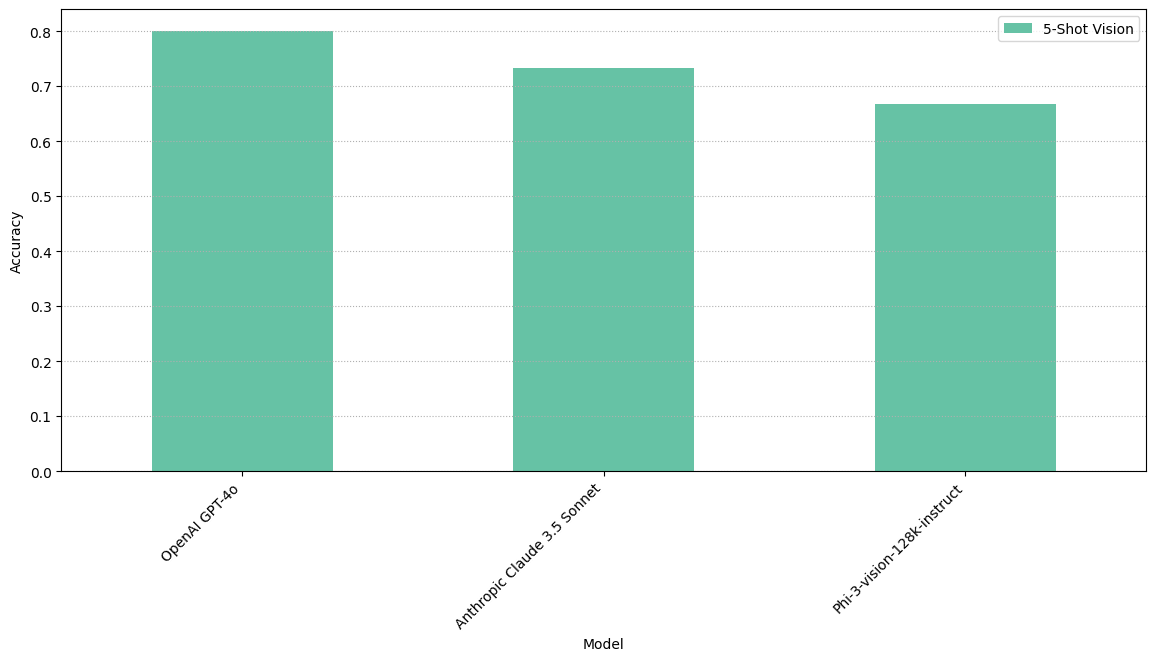

In [132]:
CCNP_Vision_path = [
    "../results/15_questions_5_Shot_HELM_350-701-CCNP-VISION_2024_08_07_16_48",
    ]
CCNP_Vision_Stats = stats_from_pickle(CCNP_Vision_path,cot=False)
title="CCNP 350-701 Vision"
#plot_evaluation_CCNA(CCNP_Vision_Stats, hline_accuracy=0.8, hline_partial=0.8, title=title)

# Define colors for the models
colors = plt.cm.Set2(np.linspace(0, 1, len(CCNP_Vision_Stats)))
#merged_df.set_index('Model', inplace=True)
CCNP_Vision_Stats.set_index("Model")[["Accuracy Mean"]].rename(columns={'Accuracy Mean': '5-Shot Vision'}).plot(kind='bar', figsize=(14, 6),color=colors)

plt.ylabel('Accuracy')
#plt.title('5-shot vs Chain-of-Thought')
plt.xticks(rotation=45, ha='right')
plt.grid(True, linestyle='dotted', axis='y')
#plt.show()


plt.show()